# Winter 2026 COMP 579 Assignment 2 Starter Code

In this assignment, you will experiment with different algorithms to evaluate a given fixed policy.

Following the instructions in the questions document, fill in the missing code indicated by "TODO" marks.

In [ ]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import gymnasium as gym
from collections import defaultdict
from typing import Dict, Tuple, List

## Question 1

Do NOT change the RANDOM_SEED value set in the next code cell. This ensures reproducibility.

In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

We will start by initialising our environment:

> Before you proceed, we recommend that you check the Gymnasium Documentation: https://gymnasium.farama.org/ and play around with the Frozen Lake environment https://gymnasium.farama.org/environments/toy_text/frozen_lake/ to get more comfortable with Gym, as you will be frequently using it in RL and the next assignment.





In [ ]:
env = gym.make("FrozenLake-v1", is_slippery=True)
env.reset(seed=RANDOM_SEED)

(0, {'prob': 1})

In [ ]:
number_of_states = env.observation_space.n
number_of_actions = env.action_space.n

states = list(range(number_of_states))
actions = list(range(number_of_actions))

print("States:", number_of_states)
print("Actions:", number_of_actions)

States: 16
Actions: 4


In Frozen Lake, the action space is defined as:

```
0: Move left
1: Move down
2: Move right
3: Move up
```




In [ ]:
P = env.unwrapped.P

`P` gives the transition information for the Markov Decision Process (MDP). In Gym’s tabular environments (like FrozenLake), `P` is a dictionary of dictionaries of lists

In [ ]:
P

{0: {0: [(0.33333333333333337, 0, 0, False),
   (0.3333333333333333, 0, 0, False),
   (0.33333333333333337, 4, 0, False)],
  1: [(0.33333333333333337, 0, 0, False),
   (0.3333333333333333, 4, 0, False),
   (0.33333333333333337, 1, 0, False)],
  2: [(0.33333333333333337, 4, 0, False),
   (0.3333333333333333, 1, 0, False),
   (0.33333333333333337, 0, 0, False)],
  3: [(0.33333333333333337, 1, 0, False),
   (0.3333333333333333, 0, 0, False),
   (0.33333333333333337, 0, 0, False)]},
 1: {0: [(0.33333333333333337, 1, 0, False),
   (0.3333333333333333, 0, 0, False),
   (0.33333333333333337, 5, 0, True)],
  1: [(0.33333333333333337, 0, 0, False),
   (0.3333333333333333, 5, 0, True),
   (0.33333333333333337, 2, 0, False)],
  2: [(0.33333333333333337, 5, 0, True),
   (0.3333333333333333, 2, 0, False),
   (0.33333333333333337, 1, 0, False)],
  3: [(0.33333333333333337, 2, 0, False),
   (0.3333333333333333, 1, 0, False),
   (0.33333333333333337, 0, 0, False)]},
 2: {0: [(0.33333333333333337, 2, 0



`P[state][action]` is a list of possible outcomes when taking "action" in a particular "state", because taking an action in a stochastic environment can lead to multiple next states with different probabilities.
Each element in this list is a tuple of the form:
`(transition probability, next state, reward, is the next next a terminal state?)`


In [ ]:
P[0][1]

[(0.33333333333333337, 0, 0, False),
 (0.3333333333333333, 4, 0, False),
 (0.33333333333333337, 1, 0, False)]

So `P[0][1]` shows all possible outcomes of taking action 1 in state 0, including how likely each outcome is, the resulting state, the reward, and whether the episode ends.

We can visualize our grid by checking the "desc" attribute

In [ ]:
env.unwrapped.desc

array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

```
“S” for Start tile
“G” for Goal tile
“F” for frozen tile
“H” for a tile with a hole
```




### Configs

In [ ]:
GAMMA = 0.9
CONVERGENCE_THRESHOLD = 1e-8

### Implementing the Policy

In [ ]:
def get_terminal_states(P):
    terminal_states = set()
    # TODO

    for s in P.keys():
        all_terminal = True
        for a in P[s].keys():
            for (prob, next_s, reward, done) in P[s][a]:
                if prob > 0 and not done:
                    all_terminal = False
                    break
            if not all_terminal:
                break
        if all_terminal:
            terminal_states.add(s)

    return terminal_states

In [ ]:
terminal_states = get_terminal_states(P)
terminal_states

{5, 7, 11, 12, 15}

In [ ]:
desc = env.unwrapped.desc
print(desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [ ]:
RIGHT = 2

In [ ]:
def get_valid_actions(env, s):
  """
  Given an env and a state, return a list of valid actions at this state.
  An action is valid if it leads to a different state with non-zero probability
  """
  valid_actions = []
  for a in range(env.action_space.n):
      for (prob, next_s, _, _) in P[s][a]:
          if prob > 0 and next_s != s:
              valid_actions.append(a)
              break
  return valid_actions

In [ ]:
def right_favoring_policy(env, s):
  pi = np.zeros(number_of_actions)
   # TODO

  if s in terminal_states:
        return pi

  valid_actions = get_valid_actions(env, s)
  if len(valid_actions) == 0:
      return pi

  if RIGHT in valid_actions:
      pi[RIGHT] = 0.7
      other_valid_actions = [a for a in valid_actions if a != RIGHT]
      if len(other_valid_actions) > 0:
          prob_per_other = 0.3 / len(other_valid_actions)
          for a in other_valid_actions:
              pi[a] = prob_per_other
  else:
      prob_per_action = 1.0 / len(valid_actions)
      for a in valid_actions:
          pi[a] = prob_per_action

  return pi

### Deriving $v_\pi$ with Matrix Inversion

In [ ]:
def policy_evaluation_analytical(env, policy, gamma):
  # TODO

  n_states = number_of_states
  P_pi = np.zeros((n_states, n_states))
  R_pi = np.zeros(n_states)

  for s in range(n_states):
      pi_s = policy(env, s)
      for a in range(number_of_actions):
          if pi_s[a] > 0:
              for (prob, next_s, reward, done) in P[s][a]:
                  P_pi[s, next_s] += pi_s[a] * prob
                  R_pi[s] += pi_s[a] * prob * reward

  I = np.eye(n_states)
  V = np.linalg.solve(I - gamma * P_pi, R_pi)
  return V

In [ ]:
V_analytical = policy_evaluation_analytical(env, right_favoring_policy, gamma=GAMMA)
V_analytical

array([0.00917343, 0.00857936, 0.02013823, 0.00394009, 0.01316506,
       0.        , 0.04764794, 0.        , 0.0351977 , 0.10546422,
       0.15633561, 0.        , 0.        , 0.22254004, 0.49621811,
       0.        ])

### Synchronous DP

In [ ]:
def synchronous_policy_evaluation(P, policy, gamma, tol):
  V = np.zeros(number_of_states)
  residuals = []

  # TODO

  while True:
    V_new = np.zeros(number_of_states)

    for s in range(number_of_states):
        pi_s = policy(env, s)
        v = 0
        for a in range(number_of_actions):
            if pi_s[a] > 0:
                for (prob, next_s, reward, done) in P[s][a]:
                    v += pi_s[a] * prob * (reward + gamma * V[next_s])
        V_new[s] = v

    residual = np.linalg.norm(V_new - V, ord=np.inf)
    residuals.append(residual)

    if residual < tol:
        V = V_new
        break

    V = V_new

  return V, residuals

In [ ]:
V_sync, residuals = synchronous_policy_evaluation(P, right_favoring_policy, GAMMA, CONVERGENCE_THRESHOLD)

In [ ]:
V_sync

array([0.00917341, 0.00857935, 0.02013822, 0.00394008, 0.01316505,
       0.        , 0.04764793, 0.        , 0.03519769, 0.10546421,
       0.15633561, 0.        , 0.        , 0.22254003, 0.4962181 ,
       0.        ])

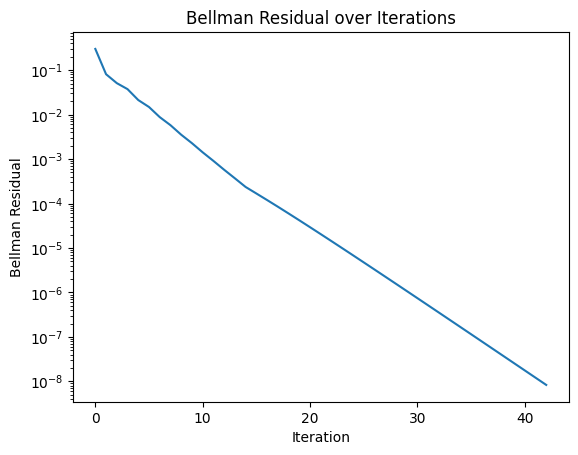

In [ ]:
plt.figure()
plt.plot(residuals)
plt.yscale("log")
plt.title("Bellman Residual over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Bellman Residual")
plt.show()

### Value Function Visualization

In [ ]:
def plot_value_heatmap(env, V, title):
  # TODO
  desc = env.unwrapped.desc
  grid_shape = desc.shape
  V_grid = V.reshape(grid_shape)

  plt.figure(figsize=(8, 6))
  sns.heatmap(V_grid, annot=False, fmt=".3f", cmap="YlOrRd", cbar=True)

  for i in range(grid_shape[0]):
      for j in range(grid_shape[1]):
          state_idx = i * grid_shape[1] + j
          tile_type = desc[i, j].decode('utf-8')
          value = V[state_idx]

          plt.text(j + 0.5, i + 0.3, tile_type,
                  ha='center', va='center', color='black',
                  fontsize=14, fontweight='bold')
          plt.text(j + 0.5, i + 0.7, f'{value:.3f}',
                  ha='center', va='center', color='black', fontsize=10)

  plt.title(title)
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.tight_layout()
  plt.show()

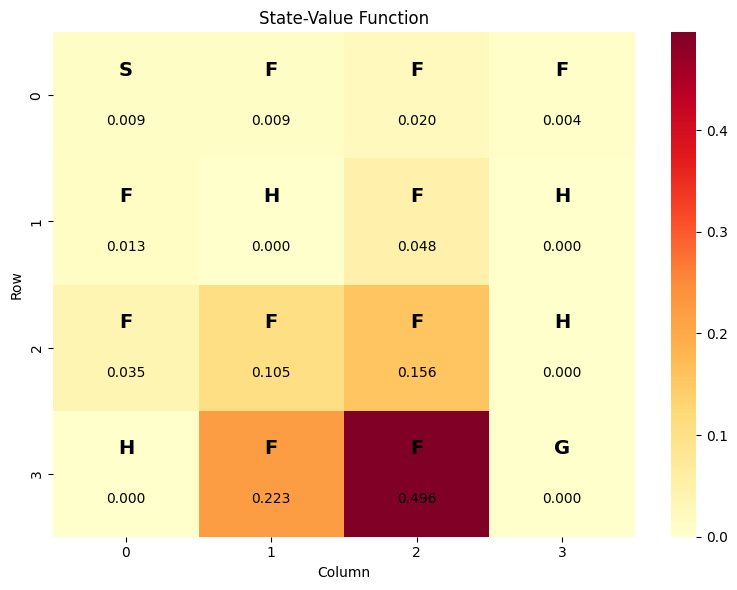

In [ ]:
plot_value_heatmap(env, V_sync, title="State-Value Function")

### Non-stationary

In [ ]:
def uniform_random_policy(env, s):
  pi = np.zeros(number_of_actions) # action-probability vector at state s

  #TODO

  if s in terminal_states:
        return pi

  valid_actions = get_valid_actions(env, s)
  if len(valid_actions) == 0:
      return pi

  prob_per_action = 1.0 / len(valid_actions)
  for a in valid_actions:
      pi[a] = prob_per_action

  return pi

In [ ]:
def non_stationary_policy_evaluation(P, policy_A, policy_B, gamma, total_steps, switch_interval):
  V = np.zeros(number_of_states)
  residuals = []
  V_norms = []

  # TODO

  for iteration in range(total_steps):
    policy_switches = iteration // switch_interval
    if policy_switches % 2 == 0:
        current_policy = policy_A
    else:
        current_policy = policy_B

    V_new = np.zeros(number_of_states)

    for s in range(number_of_states):
        pi_s = current_policy(env, s)
        v = 0
        for a in range(number_of_actions):
            if pi_s[a] > 0:
                for (prob, next_s, reward, done) in P[s][a]:
                    v += pi_s[a] * prob * (reward + gamma * V[next_s])
        V_new[s] = v

    residual = np.linalg.norm(V_new - V, ord=np.inf)
    residuals.append(residual)

    V_norm = np.linalg.norm(V_new, ord=2)
    V_norms.append(V_norm)

    V = V_new

  return V, residuals, V_norms

In [ ]:
non_stationary_V, non_stationary_residuals, non_stationary_V_norms = non_stationary_policy_evaluation(P, right_favoring_policy, uniform_random_policy, GAMMA, 40, 4)

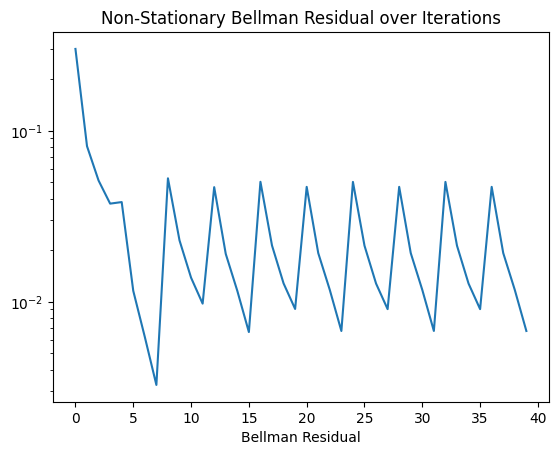

In [ ]:
plt.figure()
plt.plot(non_stationary_residuals)
plt.yscale("log")
plt.xlabel("Iteration")
plt.xlabel("Bellman Residual")
plt.title("Non-Stationary Bellman Residual over Iterations")
plt.show()

## Question 2

### 2D Random Walk Environment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from itertools import zip_longest

In [ ]:
class RandomWalk2DEnv:

    def __init__(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        self.reset()

    def reset(self):
        self.state = np.array([0.5, 0.5])
        return self.state.copy()

    def sample_action(self):
        return np.array([
            random.uniform(-0.2, 0.2),
            random.uniform(-0.2, 0.2)
        ])

    def step(self, action):
        next_state = self.state + action

        # Check termination
        done = (
            next_state[0] < 0 or next_state[0] > 1 or
            next_state[1] < 0 or next_state[1] > 1
        )

        # Reward function
        reward = next_state[0] + next_state[1] if done else 0.0

        self.state = next_state
        return next_state.copy(), reward, done


### Tile coding software (from incompleteideas.net)

In [ ]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        return (
            "Collision table:"
            + " size:" + str(self.size)
            + " overfullCount:" + str(self.overfullCount)
            + " dictionary:" + str(len(self.dictionary)) + " items"
        )

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount == 0:
                print("IHT full, starting to allow collisions")
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m) == IHT:
        return m.getindex(tuple(coordinates), readonly)
    if type(m) == int:
        return basehash(tuple(coordinates)) % m
    if m is None:
        return coordinates


def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """Returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """Returns num-tilings tile indices with wrapping"""
    qfloats = [floor(f * numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b % numtilings) // numtilings
            coords.append(c % width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


### Fixed tiling parameters

In [ ]:
NUM_TILINGS = 8
TILES_PER_DIM = 4          # 4 x 4 per tiling
IHT_SIZE = 4096

# Global index hash table
iht = IHT(IHT_SIZE)

In [ ]:
def tile_coding_indices(state):

    x, y = state

    return tiles(
        ihtORsize=iht,
        numtilings=NUM_TILINGS,
        floats=[x * TILES_PER_DIM, y * TILES_PER_DIM]
    )

def tile_coding_feature_vector(state):

    phi = np.zeros(IHT_SIZE)
    for idx in tile_coding_indices(state):
        phi[idx] = 1.0
    return phi


### Test

In [ ]:
s = (0.5, 0.5)
idx = tile_coding_indices(s)

print("Active tiles:", idx)
print("Number of active tiles:", len(idx))  # should be 8


Active tiles: [0, 1, 2, 3, 4, 5, 6, 7]
Number of active tiles: 8


### Part b)

#### Every-visit Monte Carlo Agent

In [ ]:
class MCAgentTileCoding:
    def __init__(self, alpha=0.1):
        ## TODO: initialize alpha and weights
        #pass
        self.alpha = alpha
        self.weights = np.zeros(IHT_SIZE)

    def value(self, state):
        ## TODO: compute sum of weights for active tiles
        #pass
        active_indices = tile_coding_indices(state)
        return np.sum(self.weights[active_indices])

    def update_episode(self, episode):
        ## TODO: compute returns Gt
        ## TODO: update weights for each state in the episode
        #pass
        G = 0

        for t in range(len(episode) - 1, -1, -1):
            state, reward = episode[t]
            G = reward + G

            active_indices = tile_coding_indices(state)

            current_value = self.value(state)

            # TD-style update for each active tile
            # Weight update: w += alpha * (G - V(s)) * (1 for each active tile)
            delta = self.alpha / NUM_TILINGS * (G - current_value)

            for idx in active_indices:
                self.weights[idx] += delta

#### Run MC experiments

In [ ]:
def run_mc_experiment(
    learning_rates=[0.1, 0.03, 0.01, 0.003, 0.001],
    num_episodes=1000,
    num_runs=30
):
    """
    Run every-visit Monte Carlo prediction experiments using Tile Coding.
    Returns mean and std of MSVE for each learning rate.
    """
    mean_msve = {}  # placeholder
    std_msve = {}   # placeholder

    ## TODO: Implement experiment loop over alphas, runs, episodes
    for alpha in learning_rates:
        print(f"Running MC experiments for alpha={alpha}")
        msve_runs = []

        for run in range(num_runs):
            env = RandomWalk2DEnv(seed=42 + run)
            agent = MCAgentTileCoding(alpha=alpha)

            for episode_num in range(num_episodes):
                episode = []
                state = env.reset()
                done = False

                while not done:
                    action = env.sample_action()
                    next_state, reward, done = env.step(action)
                    episode.append((state, reward))
                    state = next_state

                agent.update_episode(episode)

            msve = compute_msve(agent)
            msve_runs.append(msve)

        mean_msve[alpha] = np.mean(msve_runs)
        std_msve[alpha] = np.std(msve_runs)
        print(f"  Mean MSVE: {mean_msve[alpha]:.5f} ± {std_msve[alpha]:.5f}")

    return mean_msve, std_msve

#### MSVE Evaluation

In [ ]:
def compute_msve(agent):
    """
    Compute the Mean Squared Value Error (MSVE) over a 21x21 grid
    in [0,1] x [0,1] using the true value function V(x, y) = x + y.
    """
    msve = 0.0  # placeholder

    ## TODO: Compute MSVE over grid for the given agent
    # 21x21 grid, spacing of 0.05
    count = 0
    for x in np.linspace(0, 1, 21):
        for y in np.linspace(0, 1, 21):
            state = (x, y)
            true_value = x + y
            estimated_value = agent.value(state)
            msve += (estimated_value - true_value) ** 2
            count += 1

    msve /= count
    return msve

#### Main execution

Running MC experiments for alpha=0.1
  Mean MSVE: 0.05494 ± 0.02149
Running MC experiments for alpha=0.03
  Mean MSVE: 0.05041 ± 0.00800
Running MC experiments for alpha=0.01
  Mean MSVE: 0.09361 ± 0.00691
Running MC experiments for alpha=0.003
  Mean MSVE: 0.23532 ± 0.00954
Running MC experiments for alpha=0.001
  Mean MSVE: 0.49607 ± 0.01018
Mean MSVE ± Std Dev over 30 runs after 1000 episodes:
α=0.1: 0.05494 ± 0.02149
α=0.03: 0.05041 ± 0.00800
α=0.01: 0.09361 ± 0.00691
α=0.003: 0.23532 ± 0.00954
α=0.001: 0.49607 ± 0.01018


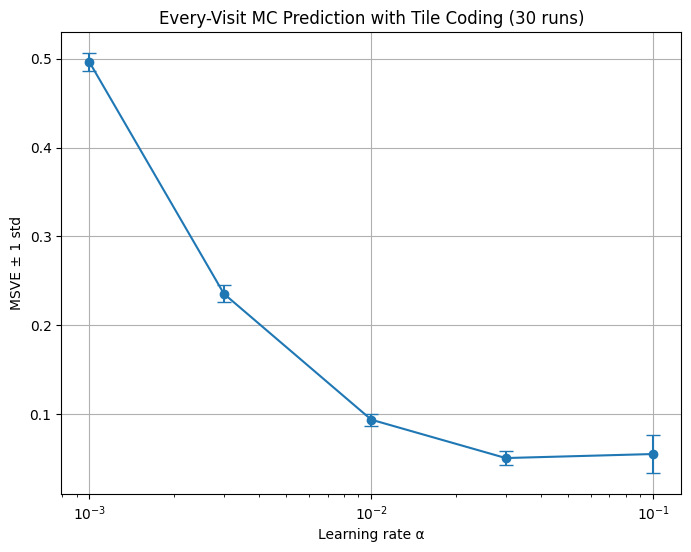

In [ ]:
def plot_mc_results(mean_msve, std_msve):
    alphas = list(mean_msve.keys())
    means = np.array(list(mean_msve.values()))
    stds = np.array(list(std_msve.values()))

    plt.figure(figsize=(8,6))
    plt.errorbar(alphas, means, yerr=stds, fmt='o-', capsize=5)
    plt.xscale('log')
    plt.xlabel("Learning rate α")
    plt.ylabel("MSVE ± 1 std")
    plt.title("Every-Visit MC Prediction with Tile Coding (30 runs)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    learning_rates = [0.1, 0.03, 0.01, 0.003, 0.001]

    mean_msve, std_msve = run_mc_experiment(
        learning_rates=learning_rates,
        num_episodes=1000,
        num_runs=30
    )

    print("Mean MSVE ± Std Dev over 30 runs after 1000 episodes:")
    for alpha in learning_rates:
        print(f"α={alpha}: {mean_msve[alpha]:.5f} ± {std_msve[alpha]:.5f}")

    plot_mc_results(mean_msve, std_msve)


### Part c)

#### TD(λ) Agent (Accumulating Traces)

In [ ]:
class TDAgentLambda:
    def __init__(self, alpha=0.01, gamma=1.0, lam=0.5):
        """
        alpha: learning rate
        gamma: discount factor
        lam: trace decay parameter
        """
        ## TODO: initialize weights and eligibility traces ##
        self.alpha = alpha
        self.gamma = gamma
        self.lam = lam
        self.weights = np.zeros(IHT_SIZE)
        self.traces = np.zeros(IHT_SIZE)

    def value(self, state):
        """
        Return the current value estimate for a given state.
        """
        ## TODO: compute value from active tile indices ##
        active_indices = tile_coding_indices(state)
        return np.sum(self.weights[active_indices])


    def reset_traces(self):
        """
        Reset eligibility traces at the start of each episode.
        """
        ## TODO: reset eligibility traces ##
        self.traces = np.zeros(IHT_SIZE)

    def update(self, state, reward, next_state, done):
        """
        Perform a TD(lambda) update for a single step.
        """
        ## TODO: update weights using accumulating traces ##
        active_indices = tile_coding_indices(state)
        V_s = self.value(state)
        V_next = 0.0 if done else self.value(next_state)
        delta = reward + self.gamma * V_next - V_s

        for idx in active_indices:
            self.traces[idx] += 1.0

        # w += alpha * delta * z
        self.weights += self.alpha * delta * self.traces

        # apply decay traces op
        self.traces *= self.gamma * self.lam

#### Run TD(λ) Experiments

In [ ]:
def run_td_lambda_experiment(
    lambdas=[0, 0.25, 0.5, 0.75, 0.9],
    alphas=[0.001, 0.003, 0.01, 0.03, 0.1],
    num_episodes=1000,
    num_runs=30
):
    results = {}

    ## TODO:
    # Loop over lambdas and alphas
    # For each seed, initialize env with seed and TDAgentLambda
    # Run num_episodes, update agent each step
    # Compute MSVE over 21x21 grid
    # Average MSVE over runs and store in results

    for lam in lambdas:
        for alpha in alphas:
            print(f"Running TD(λ) for λ={lam}, α={alpha}")
            msve_runs = []

            for run in range(num_runs):
                env = RandomWalk2DEnv(seed=42 + run)
                agent = TDAgentLambda(alpha=alpha, gamma=1.0, lam=lam)

                for episode_num in range(num_episodes):
                    agent.reset_traces()
                    state = env.reset()
                    done = False

                    while not done:
                        action = env.sample_action()
                        next_state, reward, done = env.step(action)
                        agent.update(state, reward, next_state, done)
                        state = next_state

                msve = compute_msve(agent)
                msve_runs.append(msve)

            results[(lam, alpha)] = np.mean(msve_runs)
            print(f"  Mean MSVE: {results[(lam, alpha)]:.5f}")

    return results


#### Plot 1: MSVE vs α (one curve per λ)

In [ ]:
def plot_msve_vs_alpha(results, lambdas, alphas):
    plt.figure(figsize=(8, 6))

    for lam in lambdas:
        msves = [results[(lam, alpha)] for alpha in alphas]
        plt.plot(alphas, msves, marker='o', label=f"λ={lam}")

    plt.xscale("log")
    plt.xlabel("Learning rate α")
    plt.ylabel("Average MSVE")
    plt.title("TD(λ): MSVE vs α")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot 2: MSVE vs λ (one curve per α)

In [ ]:
def plot_msve_vs_lambda(results, lambdas, alphas):
    plt.figure(figsize=(8, 6))

    for alpha in alphas:
        msves = [results[(lam, alpha)] for lam in lambdas]
        plt.plot(lambdas, msves, marker='o', label=f"α={alpha}")

    plt.xlabel("λ")
    plt.ylabel("Average MSVE")
    plt.title("TD(λ): MSVE vs λ")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot 3: Heatmap (λ × α)

In [ ]:
import pandas as pd

def plot_heatmap(results):
    df = pd.DataFrame(
        [(lam, alpha, msve) for (lam, alpha), msve in results.items()],
        columns=["lambda", "alpha", "MSVE"]
    )

    heatmap_data = df.pivot(index="lambda", columns="alpha", values="MSVE")

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis")
    plt.xlabel("Learning rate α")
    plt.ylabel("λ")
    plt.title("TD(λ) with Accumulating Traces: MSVE")
    plt.show()


#### Main Execution

Running TD(λ) for λ=0, α=0.001
  Mean MSVE: 0.52538
Running TD(λ) for λ=0, α=0.003
  Mean MSVE: 0.12813
Running TD(λ) for λ=0, α=0.01
  Mean MSVE: 0.02416
Running TD(λ) for λ=0, α=0.03
  Mean MSVE: 0.01672
Running TD(λ) for λ=0, α=0.08
  Mean MSVE: 0.02620
Running TD(λ) for λ=0.25, α=0.001
  Mean MSVE: 0.41383
Running TD(λ) for λ=0.25, α=0.003
  Mean MSVE: 0.08929
Running TD(λ) for λ=0.25, α=0.01
  Mean MSVE: 0.02323
Running TD(λ) for λ=0.25, α=0.03
  Mean MSVE: 0.01761
Running TD(λ) for λ=0.25, α=0.08
  Mean MSVE: 0.02913
Running TD(λ) for λ=0.5, α=0.001
  Mean MSVE: 0.28738
Running TD(λ) for λ=0.5, α=0.003
  Mean MSVE: 0.06378
Running TD(λ) for λ=0.5, α=0.01
  Mean MSVE: 0.02315
Running TD(λ) for λ=0.5, α=0.03
  Mean MSVE: 0.02000
Running TD(λ) for λ=0.5, α=0.08
  Mean MSVE: 0.03794
Running TD(λ) for λ=0.75, α=0.001
  Mean MSVE: 0.16925
Running TD(λ) for λ=0.75, α=0.003
  Mean MSVE: 0.05166
Running TD(λ) for λ=0.75, α=0.01
  Mean MSVE: 0.02485
Running TD(λ) for λ=0.75, α=0.03
  Mean 

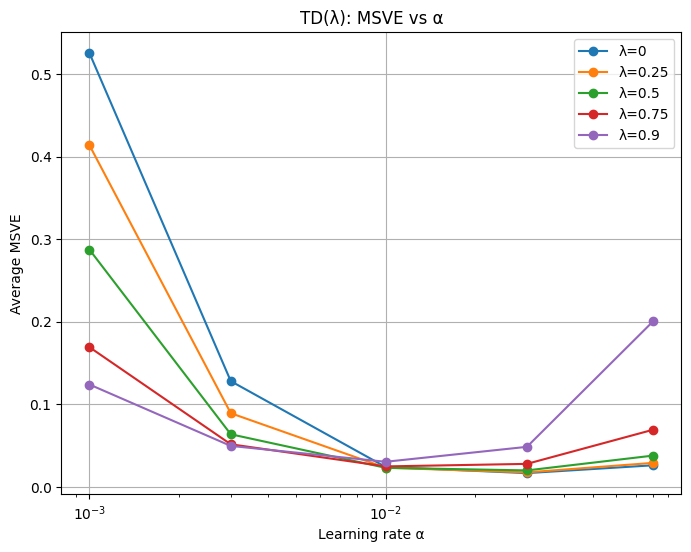

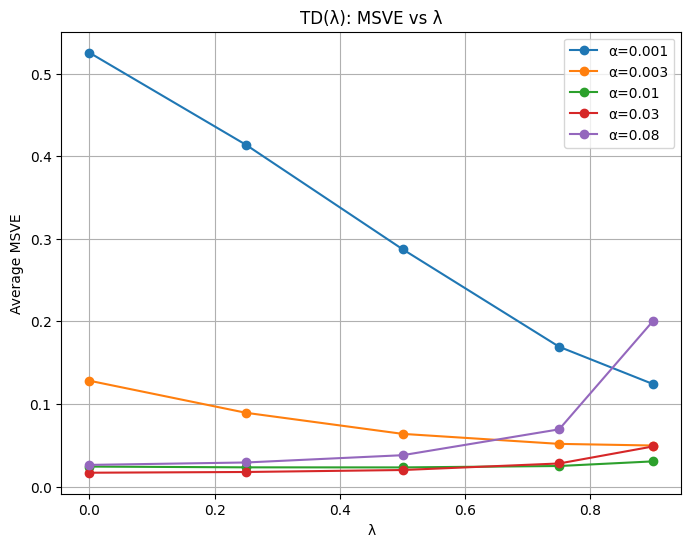

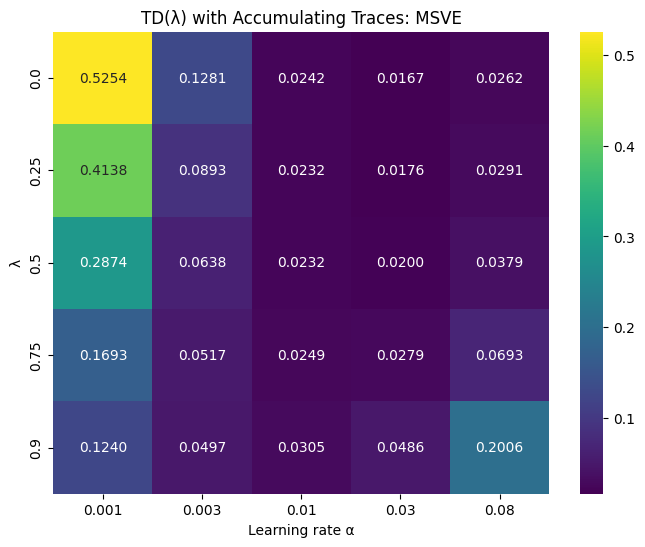

In [ ]:
lambdas = [0, 0.25, 0.5, 0.75, 0.9]
alphas = [0.001, 0.003, 0.01, 0.03, 0.08]

results = run_td_lambda_experiment(
    lambdas=lambdas,
    alphas=alphas,
    num_episodes=1000,
    num_runs=30
)

print("Average MSVE over 30 runs after 1000 episodes:")
for (lam, alpha), msve in results.items():
    print(f"λ={lam}, α={alpha}: MSVE={msve:.5f}")

plot_msve_vs_alpha(results, lambdas, alphas)
plot_msve_vs_lambda(results, lambdas, alphas)
plot_heatmap(results)


### Part d)

#### TD(0) agent with Tile Coding

In [ ]:
class TDAgentTileCoding:
    def __init__(self, alpha=0.1, gamma=1.0):
        ## TODO: initialize alpha, gamma, and weights for tile coding
        self.alpha = alpha
        self.gamma = gamma
        self.weights = np.zeros(IHT_SIZE)

    def value(self, state):
        """Estimate value of a state using tile coding."""
        ## TODO: return estimated value using active tile indices
        active_indices = tile_coding_indices(state)
        return np.sum(self.weights[active_indices])

    def update(self, state, reward, next_state, done):
        """TD(0) update for a single transition."""
        ## TODO: compute TD error and update weights for active tiles
        active_indices = tile_coding_indices(state)
        V_s = self.value(state)
        V_next = 0.0 if done else self.value(next_state)
        delta = reward + self.gamma * V_next - V_s
        for idx in active_indices:
            self.weights[idx] += (self.alpha / NUM_TILINGS) * delta

#### TD(0) agent with 2-layer Neural Network

In [ ]:
class NNValueFunction:
    def __init__(self, input_dim=2, hidden_dim=64, alpha=1e-3, gamma=1.0):
        self.alpha = alpha
        self.gamma = gamma
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) / np.sqrt(hidden_dim)
        self.b2 = np.zeros(1)

    def forward(self, state):
        self.z1 = np.dot(state, self.W1) + self.b1
        self.h1 = np.tanh(self.z1)
        value = np.dot(self.h1, self.W2) + self.b2
        return value.item()

    def td_update(self, state, reward, next_state, done):
        ## TODO: compute TD target
        ## TODO: compute TD error
        ## TODO: backpropagate TD error through network
        ## TODO: update weights W1, W2 and biases b1, b2 using alpha

        # current value is the forward pass
        V_s = self.forward(state)

        if done:
            td_target = reward
        else:
            V_next = self.forward(next_state)
            td_target = reward + self.gamma * V_next

        td_error = td_target - V_s
        state_vec = np.array(state).reshape(1, -1)
        z1 = np.dot(state_vec, self.W1) + self.b1
        h1 = np.tanh(z1)

        # Backward pass
        # dL/dW2 = dL/dV * dV/dW2 = -td_error * h1
        dW2 = -td_error * h1.T
        db2 = -td_error

        # dL/dh1 = dL/dV * dV/dh1 = -td_error * W2
        dh1 = -td_error * self.W2.T

        # dL/dz1 = dL/dh1 * dh1/dz1 = dh1 * (1 - tanh^2(z1))
        dz1 = dh1 * (1 - h1**2)

        # dL/dW1 = dz1 * state
        dW1 = np.dot(state_vec.T, dz1)
        db1 = dz1.flatten()

        # gradient descent update)
        self.W2 -= self.alpha * dW2
        self.b2 -= self.alpha * db2
        self.W1 -= self.alpha * dW1
        self.b1 -= self.alpha * db1

    def value(self, state):
        return self.forward(state)


#### Training

In [ ]:
def train_agents(env, num_episodes=2000):

    tile_agent = TDAgentTileCoding(alpha=0.1)
    nn_agent = NNValueFunction(alpha=1e-3)

    tile_values = []
    nn_values = []

    # ===========================
    # TODO: Implement training loop
    # ===========================
    # For each episode:
    # 1. Reset environment
    # 2. For Tile Coding agent:
    #    - Take steps until termination
    #    - Update the tile_agent using TD(0)
    # 3. For Neural Network agent:
    #    - Reset environment again
    #    - Take steps until termination
    #    - Update the nn_agent using td_update
    # 4. Record the value of the center state [0.5, 0.5] for both agents
    for episode_num in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = env.sample_action()
            next_state, reward, done = env.step(action)
            tile_agent.update(state, reward, next_state, done)
            state = next_state

        tile_values.append(tile_agent.value((0.5, 0.5)))
        state = env.reset()
        done = False

        while not done:
            action = env.sample_action()
            next_state, reward, done = env.step(action)
            nn_agent.td_update(state, reward, next_state, done)
            state = next_state

        nn_values.append(nn_agent.value((0.5, 0.5)))

    return tile_values, nn_values


#### Run training and plotting

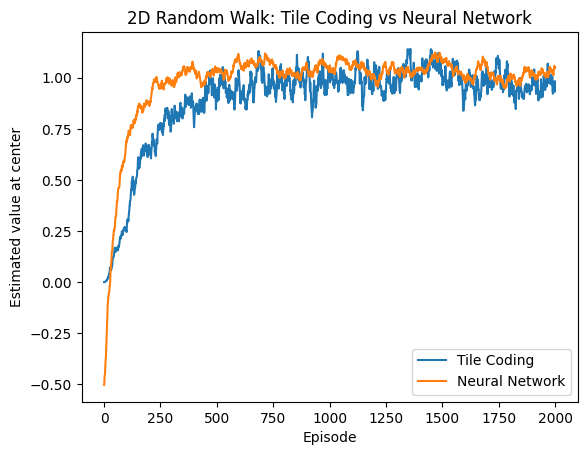

In [ ]:
env = RandomWalk2DEnv(seed=42)
tile_vals, nn_vals = train_agents(env, num_episodes=2000)

plt.plot(tile_vals, label="Tile Coding")
plt.plot(nn_vals, label="Neural Network")
plt.xlabel("Episode")
plt.ylabel("Estimated value at center")
plt.title("2D Random Walk: Tile Coding vs Neural Network")
plt.legend()
plt.show()

# Question 3

In [ ]:
GAMMA = 0.9
N = 10
r_non_terminal = 0
r_terminal = 1

In [ ]:
def linear_transiton_matrix(N):
  """
  A simple linear transition matrix for N states
  At every state (except the terminal one), the agent deterministically moves
  to s+1. At the terminal state, the agent stays in the terminal state.
  """
  P = np.zeros((N, N))

  for s in range(N-1):
        P[s, s+1] = 1.0

  P[N-1, N-1] = 1.0

  return P

In [ ]:
P = linear_transiton_matrix(N)

In [ ]:
P

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
class LinearChainEnv:
  def __init__(self, N, reward_noise=0):
    self.N = N
    self.terminal = N-1
    self.P = linear_transiton_matrix(N)

    self.reward_noise = reward_noise

    self.reset()

  def reset(self):
    self.state = 0
    return self.state

  def step(self):
    if self.state == self.terminal:
      return self.state, 0.0, True

    next_state_prob = self.P[self.state]
    next_state = np.random.choice(self.N, p=next_state_prob)

    if next_state == self.terminal:
      reward = r_terminal + np.random.randn() * self.reward_noise
    else:
      reward = r_non_terminal + np.random.randn() * self.reward_noise

    self.state = next_state
    done = self.state == self.terminal
    return self.state, reward, done

In [ ]:
class TDAgent:
  """
  Update your implementation from Q2 to work with the new linear chain env
  Hint: Instead of tile coding, use one-hot encoding for the state (every state is a feature)
  """
  def __init__(self, num_states, alpha=0.01, gamma=GAMMA):
    #pass
    self.num_states = num_states
    self.alpha = alpha
    self.gamma = gamma
    # set oone weight per state (one-hot encoding)
    self.weights = np.zeros(num_states)

  def value(self, state):
    #pass
    return self.weights[state]

  def update(self, state, reward, next_state, done):
    #pass
    V_s = self.value(state)
    V_next = 0.0 if done else self.value(next_state)
    td_error = reward + self.gamma * V_next - V_s
    self.weights[state] += self.alpha * td_error


In [ ]:
class MCAgent:
  """
  Update your implementation from Q2 to work with the new linear chain env
  Hint: Instead of tile coding, use one-hot encoding for the state (every state is a feature)
  """
  def __init__(self, num_states, alpha=0.01, gamma=GAMMA):
    #pass
    self.num_states = num_states
    self.alpha = alpha
    self.gamma = gamma
    self.weights = np.zeros(num_states)

  def value(self, state):
    #pass
    return self.weights[state]

  def update_episode(self, episode):
    #pass
    G = 0  # Return
    for t in range(len(episode) - 1, -1, -1):
        state, reward = episode[t]
        G = reward + self.gamma * G

        V_s = self.value(state)
        self.weights[state] += self.alpha * (G - V_s)

In [ ]:
def true_value_linear_chain(N, gamma, r_non_terminal=0, r_terminal=1.0):
    V = np.zeros(N)
    #TODO: Implement the true value function
    V = np.zeros(N)

    for s in range(N):
        steps_to_terminal = N - 1 - s

        if s == N - 1:
            V[s] = 0.0
        else:
            if r_non_terminal != 0:
                V[s] = r_non_terminal * (1 - gamma**steps_to_terminal) / (1 - gamma)
            else:
                V[s] = 0.0

            V[s] += (gamma**steps_to_terminal) * r_terminal
    return V

In [ ]:
V_true = true_value_linear_chain(N, GAMMA, r_non_terminal, r_terminal)

In [ ]:
def compute_msve(agent, V_true):
  # TODO: Implement the MSVE function
  #pass
  mse = 0.0
  for s in range(agent.num_states):
      error = agent.value(s) - V_true[s]
      mse += error ** 2

  return mse / agent.num_states

In [ ]:
def train_td0_and_mc(env, V_true, num_episodes=10000, lr=0.003):
  num_states = env.N

  td_agent = TDAgent(num_states, alpha=lr, gamma=GAMMA)
  mc_agent = MCAgent(num_states, alpha=lr, gamma=GAMMA)

  td_values = []
  mc_values = []
  td_msve = []
  mc_msve = []

  # TODO: Implement the training logic for the two agents
  for episode_num in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        next_state, reward, done = env.step()
        td_agent.update(state, reward, next_state, done)
        state = next_state

    td_values.append(td_agent.value(0))
    td_msve.append(compute_msve(td_agent, V_true))

    state = env.reset()
    done = False
    episode = []  # (state, reward) pairs

    while not done:
        next_state, reward, done = env.step()
        episode.append((state, reward))
        state = next_state

    mc_agent.update_episode(episode)
    mc_values.append(mc_agent.value(0))
    mc_msve.append(compute_msve(mc_agent, V_true))

  return td_agent, mc_agent, td_values, mc_values, td_msve, mc_msve

In [ ]:
# TODO: create the two versions of the LinearChainEnv

# TODO: For each env, train your agents and use the below code to plot your values and calculate mean MSVE

# plt.figure()
# plt.plot(td_values, label="TD(0)")
# plt.plot(mc_values, label="MC")
# plt.xlabel("Episode")
# plt.ylabel("V(start state)")
# plt.title("Start state value over episodes")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(td_msve, label="TD(0)")
# plt.plot(mc_msve, label="MC")
# plt.xlabel("Episode")
# plt.ylabel("MSVE")
# plt.title("Mean Squared Value Error over episodes")
# plt.legend()
# plt.show()

# mean_td_msve = sum(td_msve) / len(td_msve)
# mean_mc_msve = sum(mc_msve) / len(mc_msve)

# print("Mean MSVE TD(0):", mean_td_msve)
# print("Mean MSVE MC:", mean_mc_msve)



EXPERIMENT 1: low noise case (reward_noise = 0.01)
Expected: TD(0) MSVE > MC MSVE




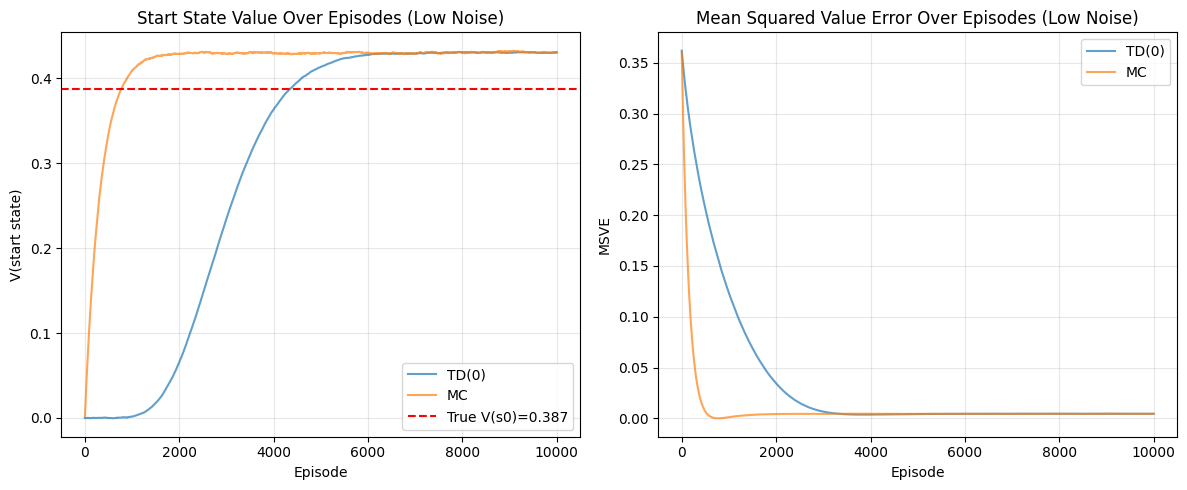


Results for Low Noise (reward_noise = 0.01):
Mean MSVE TD(0): 0.033678
Mean MSVE MC:    0.008901
Ratio (TD/MC):   3.784
SUCCESS: TD(0) MSVE > MC MSVE


EXPERIMENT 2: high noise case (reward_noise = 5.0)
Expected: MC MSVE > TD(0) MSVE




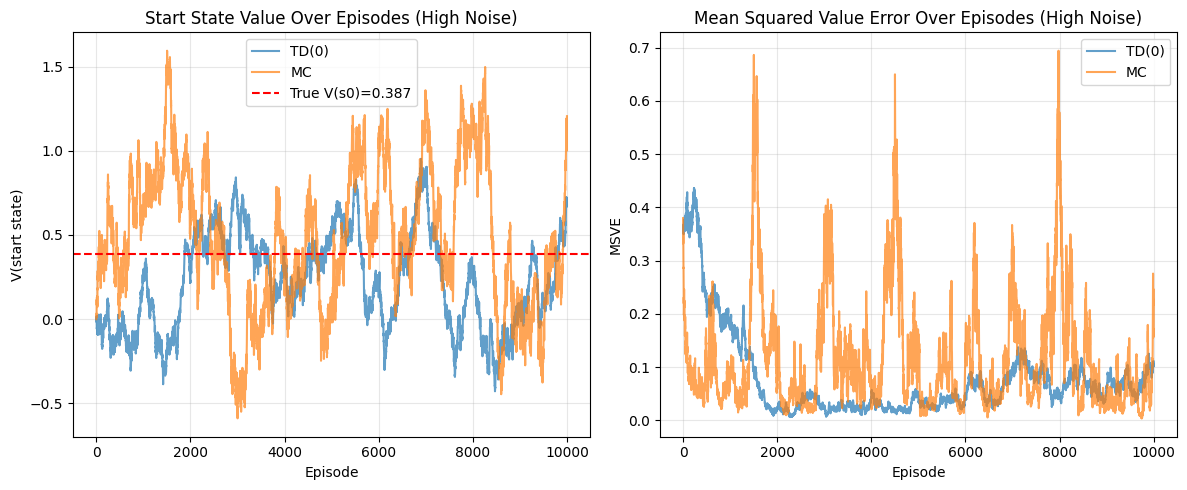


Results for High Noise (reward_noise = 5.0):
Mean MSVE TD(0): 0.077248
Mean MSVE MC:    0.116172
Ratio (MC/TD):   1.504
SUCCESS: MC MSVE > TD(0) MSVE


In [ ]:
print("\n")
print("EXPERIMENT 1: low noise case (reward_noise = 0.01)")
print("Expected: TD(0) MSVE > MC MSVE")
print("\n")

env_low_noise = LinearChainEnv(N=N, reward_noise=0.01)

td_agent_1, mc_agent_1, td_values_1, mc_values_1, td_msve_1, mc_msve_1 = train_td0_and_mc(
    env_low_noise, V_true, num_episodes=10000, lr=0.003
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(td_values_1, label="TD(0)", alpha=0.7)
plt.plot(mc_values_1, label="MC", alpha=0.7)
plt.axhline(y=V_true[0], color='r', linestyle='--', label=f"True V(s0)={V_true[0]:.3f}")
plt.xlabel("Episode")
plt.ylabel("V(start state)")
plt.title("Start State Value Over Episodes (Low Noise)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(td_msve_1, label="TD(0)", alpha=0.7)
plt.plot(mc_msve_1, label="MC", alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("MSVE")
plt.title("Mean Squared Value Error Over Episodes (Low Noise)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mean_td_msve_1 = sum(td_msve_1) / len(td_msve_1)
mean_mc_msve_1 = sum(mc_msve_1) / len(mc_msve_1)

print(f"\nResults for Low Noise (reward_noise = 0.01):")
print(f"Mean MSVE TD(0): {mean_td_msve_1:.6f}")
print(f"Mean MSVE MC:    {mean_mc_msve_1:.6f}")
print(f"Ratio (TD/MC):   {mean_td_msve_1/mean_mc_msve_1:.3f}")

if mean_td_msve_1 > mean_mc_msve_1:
    print("SUCCESS: TD(0) MSVE > MC MSVE")
else:
    print("FAILED: TD(0) MSVE <= MC MSVE")

###################################################################
print("\n")
print("EXPERIMENT 2: high noise case (reward_noise = 5.0)")
print("Expected: MC MSVE > TD(0) MSVE")
print("\n")

env_high_noise = LinearChainEnv(N=N, reward_noise=5.0)

td_agent_2, mc_agent_2, td_values_2, mc_values_2, td_msve_2, mc_msve_2 = train_td0_and_mc(
    env_high_noise, V_true, num_episodes=10000, lr=0.003
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(td_values_2, label="TD(0)", alpha=0.7)
plt.plot(mc_values_2, label="MC", alpha=0.7)
plt.axhline(y=V_true[0], color='r', linestyle='--', label=f"True V(s0)={V_true[0]:.3f}")
plt.xlabel("Episode")
plt.ylabel("V(start state)")
plt.title("Start State Value Over Episodes (High Noise)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(td_msve_2, label="TD(0)", alpha=0.7)
plt.plot(mc_msve_2, label="MC", alpha=0.7)
plt.xlabel("Episode")
plt.ylabel("MSVE")
plt.title("Mean Squared Value Error Over Episodes (High Noise)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mean_td_msve_2 = sum(td_msve_2) / len(td_msve_2)
mean_mc_msve_2 = sum(mc_msve_2) / len(mc_msve_2)

print(f"\nResults for High Noise (reward_noise = 5.0):")
print(f"Mean MSVE TD(0): {mean_td_msve_2:.6f}")
print(f"Mean MSVE MC:    {mean_mc_msve_2:.6f}")
print(f"Ratio (MC/TD):   {mean_mc_msve_2/mean_td_msve_2:.3f}")

if mean_mc_msve_2 > mean_td_msve_2:
    print("SUCCESS: MC MSVE > TD(0) MSVE")
else:
    print("FAILED: MC MSVE <= TD(0) MSVE")

### **Explain your choice of parameter value and how it affects performance in TD0 and MC:**